# Shape and index conventions in batch mode 

By default, `elvet` works in non-batch mode. This means that `equations` and `bcs` receive a local information about a single point $x$. This point is represented by a tensor with shape `x.shape == (dim_x,)` where `dim_x` is the dimension of the domain. The values of the function $y(x)$ are passed as a tensor `y` with `y.shape == (dim_y,)`. Its (higher) derivatives are then tensors of shape `(dim_x, dim_x, ..., dim_x, dim_y)`.

One can also work in batch mode by setting `batch=True` in a call to `elvet.solver`. This means that `equations` and `bcs` will receive batches of points, that is, tensors of the same shape as before, but with an extra axis of size `size` inserted in the beginning, where `size` is the number of points in the domain. In this notebook, we illustrate how to use this feature.

In [ ]:
%%capture
!pip install elvet

### Simple DE example

```python
# In non-batch mode
x.shape == (1,)
y.shape == (1,)
dy.shape == (1, 1)

# In batch mode
x.shape == (100, 1)
y.shape == (100, 1)
dy.shape == (100, 1, 1)
```

In [1]:
import elvet

def equation(x, y, dy):
    A = (1 + 3*x**2) / (1 + x + x**3)
    return dy[:,0,:] + (x + A) * y - x**3 - 2*x - x**2 * A

bc = elvet.BC(0, lambda x, y, dy: y - 1)
domain = elvet.box((0, 2, 100))

result = elvet.solver(equation, bc, domain, model=elvet.nn(1, 10, 1),batch=True, epochs=50000)

 Elvet: epoch = 1, loss = 3.50e+01, elapsed time = 00:00:00
 Elvet: epoch = 10000, loss = 3.57e-03, elapsed time = 00:00:03
 Elvet: epoch = 20000, loss = 8.20e-05, elapsed time = 00:00:05
 Elvet: epoch = 30000, loss = 5.29e-05, elapsed time = 00:00:07
 Elvet: epoch = 40000, loss = 4.33e-05, elapsed time = 00:00:09
 Elvet: epoch = 50000, loss = 3.33e-05, elapsed time = 00:00:12


### Simple PDE example

```python
x.shape == (121, 2)
d2y.shape = (121, 2, 1)

# Option 1
x1, x2 = elvet.unstack(x)
x1.shape == (121, 1)
x2.shape == (121, 1)

d2y_dx1, d2y_dx2 = elvet.math.diagonals(d2y, return_list=True)
d2y_dx1.shape == d2y_dx2.shape == (121,1)

# Option 2
x1, x2 = x[:, 0], x[:, 1]
d2y_dx1, d2y_dx2 = d2y[:, 0, 0, 0], d2y[:, 1, 1, 0]
```

 Elvet: epoch = 1, loss = 1.26e+01, elapsed time = 00:00:01
 Elvet: epoch = 10000, loss = 1.39e-02, elapsed time = 00:00:08
 Elvet: epoch = 20000, loss = 3.04e-03, elapsed time = 00:00:15
 Elvet: epoch = 30000, loss = 1.29e-03, elapsed time = 00:00:23
 Elvet: epoch = 40000, loss = 2.72e-04, elapsed time = 00:00:34
 Elvet: epoch = 50000, loss = 2.41e-04, elapsed time = 00:00:43


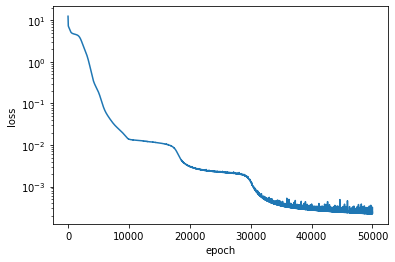

In [5]:
import elvet

def equation(x, y, dy, d2y):
    x1, x2 = elvet.unstack(x)
    return elvet.math.laplacian(d2y) - elvet.math.exp(-x1)*(x1 - 2 + x2**3 + 6 * x2)

domain = elvet.box((0, 1, 11), (0, 1, 11))

def analytical_solution(x):
    x1, x2 = elvet.unstack(x)
    return elvet.math.exp(-x1)*(x1 + x2**3)


def residuals(x, y, dy, d2y):
    return y - analytical_solution(x)

result = elvet.solver(
    equations=equation,
    bcs=(
        elvet.BC(0, residuals, index=0),  # x_1 = 0
        elvet.BC(1, residuals, index=0),  # x_1 = 1
        elvet.BC(0, residuals, index=1),  # x_2 = 0
        elvet.BC(1, residuals, index=1),  # x_2 = 1
    ),
    domain=domain,
    model=elvet.nn(2, 10, 1),
    epochs=50000,
    batch=True
)

elvet.plotting.plot_losses(result)

### Coupled DE example

```python
phi.shape == (domain_size, 1, 2)
phi1, phi2 = elvet.unstack(phi)
phi1.shape == phi2.shape == (domain_size, 1)

dphi1, dphi2 = elvet.unstack(dphi[:,0,:])
dphi1.shape == dphi2.shape == (domain_size, 1)
```

 Elvet: epoch = 1, loss = 8.21e-01, elapsed time = 00:00:00
 Elvet: epoch = 10000, loss = 1.83e-05, elapsed time = 00:00:07
 Elvet: epoch = 20000, loss = 1.49e-06, elapsed time = 00:00:17
 Elvet: epoch = 30000, loss = 9.65e-07, elapsed time = 00:00:25
 Elvet: epoch = 40000, loss = 9.38e-07, elapsed time = 00:00:31
 Elvet: epoch = 50000, loss = 5.51e-07, elapsed time = 00:00:37


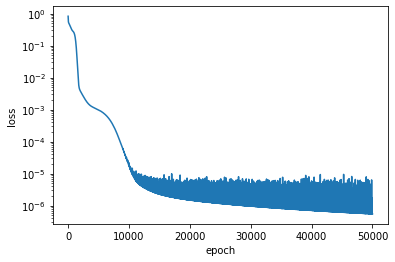

 Elvet: epoch = 1, loss = 2.16e-01, elapsed time = 00:00:00
 Elvet: epoch = 10000, loss = 6.77e-06, elapsed time = 00:00:07
 Elvet: epoch = 20000, loss = 1.94e-06, elapsed time = 00:00:14
 Elvet: epoch = 30000, loss = 1.36e-06, elapsed time = 00:00:22
 Elvet: epoch = 40000, loss = 1.48e-06, elapsed time = 00:00:29
 Elvet: epoch = 50000, loss = 8.30e-07, elapsed time = 00:00:36


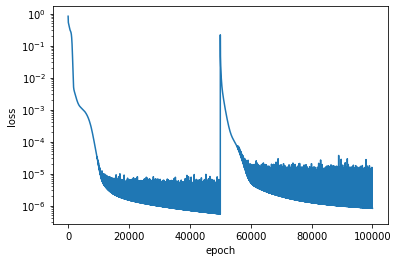

 Elvet: epoch = 1, loss = 4.35e-01, elapsed time = 00:00:00
 Elvet: epoch = 10000, loss = 7.83e-05, elapsed time = 00:00:07
 Elvet: epoch = 20000, loss = 3.21e-05, elapsed time = 00:00:14
 Elvet: epoch = 30000, loss = 1.40e-05, elapsed time = 00:00:20
 Elvet: epoch = 40000, loss = 6.93e-06, elapsed time = 00:00:27
 Elvet: epoch = 50000, loss = 4.52e-06, elapsed time = 00:00:34


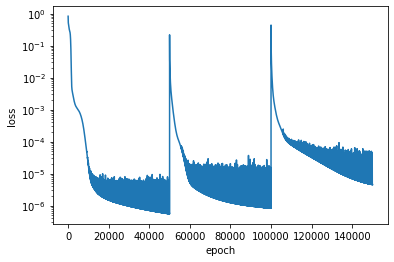

In [7]:
from elvet.math import sin, cos
domains = [elvet.box((0, x_max, 30 * x_max)) for x_max in range(1, 4)]

def equation(x, phi, dphi):
    phi1, phi2 = elvet.unstack(phi)
    dphi1, dphi2 = elvet.unstack(dphi[:,0,:])
    return (
        dphi1 - cos(x) - phi1**2 - phi2 + 1 + x**2 + sin(x)**2,
        dphi2 - 2 * x + (1 + x**2) * sin(x) - phi1 * phi2,
    )

bcs = [
    elvet.BC(0, lambda x, phi, dphi: elvet.unstack(phi)[0]),
    elvet.BC(0, lambda x, phi, dphi: elvet.unstack(phi)[1] - 1),
]

solver = elvet.solver(equation, bcs, domains[0],batch=True, model=elvet.nn(1, 10, 2))

for domain in domains:
    solver.fit(50000, domain=domain,verbose=1)
    elvet.plotting.plot_losses(solver)